Universidade Federal do Rio de Janeiro - UFRJ <br>
Programa de Pós-Graduação em Engenharia de Processos Químicos e Bioquímicos da EQ/UFRJ <br>
Disciplina EQE778 - Aprendizado de Máquina <br>

Trabalho de Reinforced Learning <br>
Aluno: Francisco Davi Belo Rodrigues

Questão 2 - Código e respostas:

In [ ]:
import os
import sys
import copy
import random
import pcgym
import optuna
import torch
import numpy as np
import gymnasium as gym
import torch.nn.functional as F
import matplotlib.pyplot as plt
from stable_baselines3 import PPO,SAC,DDPG,TD3
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
# from callback import LearningCurveCallback
from dataclasses import dataclass
from contextlib import contextmanager
from IPython.display import clear_output
from pcgym import make_env

# Define environment
T = 26
nsteps = 150

# Global seed for reproducibility
seed = 1490

"""
Control Club Challenge (PSE)
## 1. Control Problem
The environment used in the this problem is a Continuously Stirred Tank Reactor (CSTR) performing an exothermic reaction (A → B). 
The controlled variable will be the concentration of species A by manipulating the temperature of the cooling jacket. 
A diagram of the environment is given below.
"""

SP = {
    'Ca': [0.85 for i in range(int(nsteps/3))] + [0.9 for i in range(int(nsteps/3))]+ [0.87 for i in range(int(nsteps/3))],
}

disturbance = {'Caf': np.repeat([1, 1.05, 1], [nsteps//3, nsteps//3, nsteps//3])}

action_space = {
    'low': np.array([295]),
    'high':np.array([302])
}
#Continuous box observation space  Specifications (Ca,T,Ca_SP)
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])
}

r_scale = {'Ca':1e3}

disturbance_space ={
  'low': np.array([1]),
  'high': np.array([1.05])
}

In [3]:
@contextmanager
def suppress_output():
    """A context manager to suppress all output (stdout and stderr)."""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr
    clear_output(wait=False)

def train_ddpg_with_params(epsilon, nsteps_learning):
    """
    Trains a DDPG model with specified epsilon and nsteps_learning values.

    Args:
        epsilon (float): The threshold parameter for the custom reward function.
        nsteps_learning (int): Total number of steps for training.
    """

    # Define custom reward function with the provided alpha
    def r_sparse(self, x, u, con):
        """
        Sparse reward function based on the threshold epsilon.

        Parameters:
            x: np.ndarray
                Current state.
            u: np.ndarray
                Current action.
            con: object
                Additional context or parameters (if needed).
            epsilon: float
                Threshold for the squared setpoint error.

        Returns:
            reward: int
                Sparse reward (1 if error < epsilon, else 0).
        """
        
        Sp_i = 0
        squared_error = 0

        for k in self.env_params["SP"]:
            i = self.model.info()["states"].index(k)
            SP = self.SP[k]

            o_space_low = self.env_params["o_space"]["low"][i]
            o_space_high = self.env_params["o_space"]["high"][i]

            x_normalized = (x[i] - o_space_low) / (o_space_high - o_space_low)
            setpoint_normalized = (SP - o_space_low) / (o_space_high - o_space_low)

            squared_error += (np.sum(x_normalized - setpoint_normalized[self.t]) ** 2)

            Sp_i += 1
            
            if squared_error < epsilon:
                reward = 1
            else:
                reward = 0
        
        return reward

    # Define environment parameters
    env_params = {
        'N': nsteps,
        'tsim': T,
        'SP': SP,
        'o_space': observation_space,
        'a_space': action_space,
        'x0': np.array([0.8, 330, 0.8]),  # initial conditions of the state vector [Ca, T, Ca_SP]
        'r_scale': {'Ca': 1e3},
        'model': 'cstr',
        'normalise_a': True,
        'normalise_o': True,
        'noise': True,
        'integration_method': 'casadi',
        'noise_percentage': 0.001,
        'disturbance_bounds': disturbance_space,
        'disturbances': disturbance,
        'custom_reward': r_sparse
    }

    env = make_env(env_params)

    with suppress_output():
    
        n_actions = env.action_space.shape[-1]
        action_noise = OrnsteinUhlenbeckActionNoise(
            mean=np.zeros(n_actions),
            sigma=0.25 * np.ones(n_actions),
            theta=0.4,
            dt=0.028517525751839627
        )

        # Learning rate schedule
        def linear_schedule(progress):
            initial_lr = 0.0011
            final_lr = 0.0007
            return progress * (initial_lr - final_lr) + final_lr

        # Custom parameters for DDPG
        custom_params = {
            "buffer_size": 1500,
            "learning_starts": 16,
            "batch_size": 128,
            "tau": 0.006,
            "gamma": 0.961239294568761
        }

        # Directory for saving the best model
        save_path = f"best_model_epsilon_{epsilon}_steps_{nsteps_learning}"
        os.makedirs(save_path, exist_ok=True)

        # Callback for saving the best model
        eval_callback = EvalCallback(
            eval_env=env,
            best_model_save_path=save_path,
            log_path=save_path,
            eval_freq=100,
            deterministic=True,
            render=False
        )

        # Instantiate and train the DDPG model
        DDPG_CSTR = DDPG(
            "MlpPolicy",
            env,
            verbose=0,
            learning_rate=linear_schedule,
            seed=seed,
            action_noise=action_noise,
            buffer_size=custom_params["buffer_size"],
            learning_starts=custom_params["learning_starts"],
            batch_size=custom_params["batch_size"],
            tau=custom_params["tau"],
            gamma=custom_params["gamma"]
        )

        # Train the model
        DDPG_CSTR.learn(total_timesteps=int(nsteps_learning), callback=eval_callback)

    # Print the path where the best model was saved
    print(f"Best model saved at: {save_path}/best_model.zip")

    # Load the best model after training
    best_model = DDPG.load(f"{save_path}/best_model.zip")
    evaluator, data = env.plot_rollout({'DDPG': best_model}, reps=10, oracle=True, dist_reward=True)

    # Calculate and print the score
    print(f"for Epsilon: {epsilon}, Steps: {nsteps_learning}")
    score = data['DDPG']['r'].mean()
    print(f"Final score is: {score:.6f} (larger the better).")

    return evaluator, data, score

Best model saved at: best_model_epsilon_0.2_steps_70000/best_model.zip


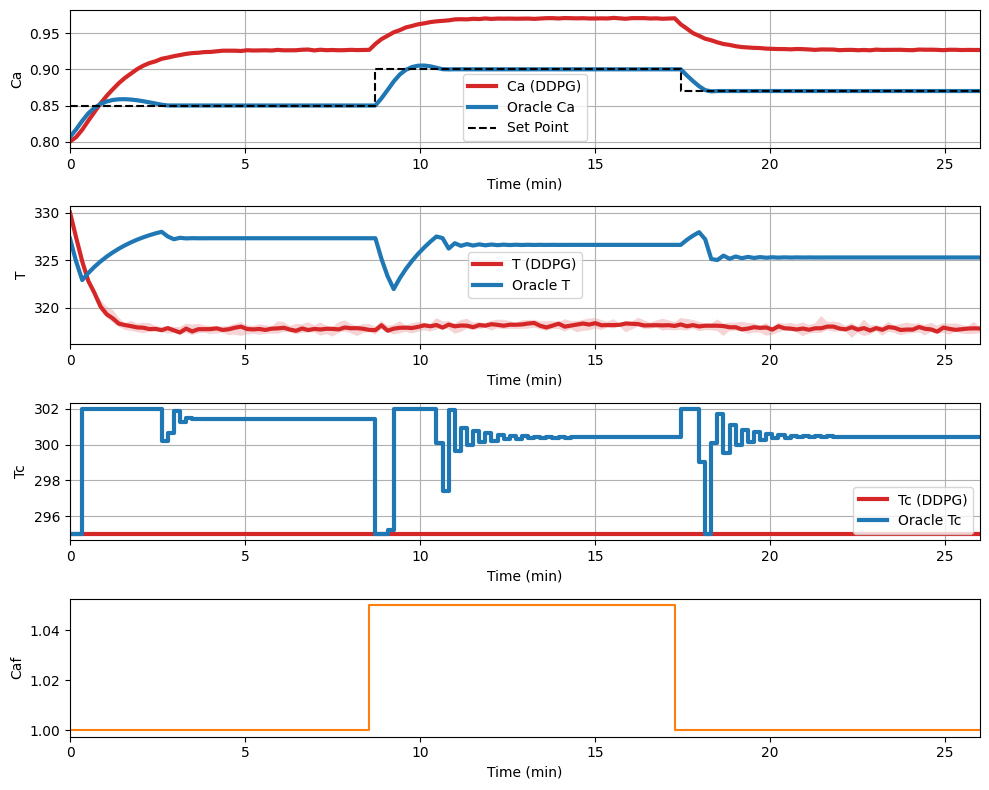

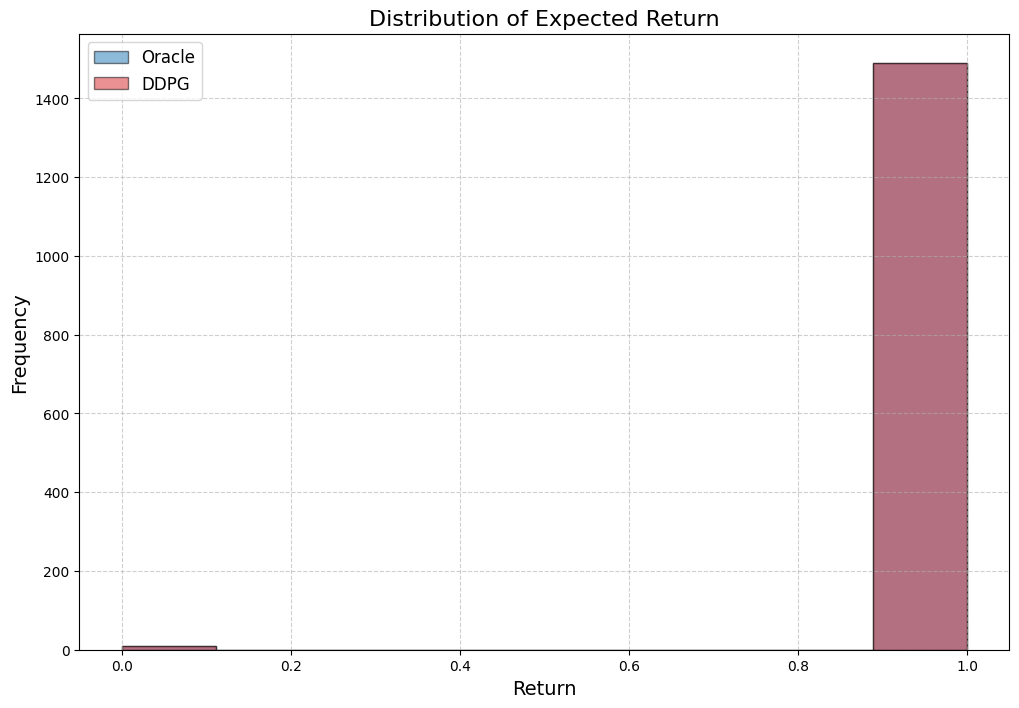

for Epsilon: 0.2, Steps: 70000
Final score is: 0.993333 (larger the better).


In [4]:
from itertools import product

# Lists for alphas and n_steps_learning
epsilon_list = [0.01, 0.05, 0.1, 0.15, 0.2]
n_steps_learning_list = [35000, 50000, 70000]

# Dictionary to store experiment results
experiment_results = {}

# Generate all combinations of alpha and n_steps_learning
for epsilon, n_steps_learning in product(epsilon_list, n_steps_learning_list):
    eva, data, score = train_ddpg_with_params(epsilon, n_steps_learning)
    experiment_results[(epsilon, n_steps_learning)] = score

In [5]:
# Print the experiment results ordered by the highest score
print("Experiment Results (Ordered by Highest Score):")

# Sort the dictionary by score in descending order
sorted_results = sorted(experiment_results.items(), key=lambda item: item[1], reverse=True)

# Print the sorted results
for params, score in sorted_results:
    print(f"Epsilon: {params[0]}, Steps: {params[1]} -> Score: {score:.6f}")

Experiment Results (Ordered by Highest Score):
Epsilon: 0.1, Steps: 35000 -> Score: 0.993333
Epsilon: 0.1, Steps: 50000 -> Score: 0.993333
Epsilon: 0.1, Steps: 70000 -> Score: 0.993333
Epsilon: 0.15, Steps: 35000 -> Score: 0.993333
Epsilon: 0.15, Steps: 50000 -> Score: 0.993333
Epsilon: 0.15, Steps: 70000 -> Score: 0.993333
Epsilon: 0.2, Steps: 35000 -> Score: 0.993333
Epsilon: 0.2, Steps: 50000 -> Score: 0.993333
Epsilon: 0.2, Steps: 70000 -> Score: 0.993333
Epsilon: 0.01, Steps: 35000 -> Score: 0.980000
Epsilon: 0.01, Steps: 50000 -> Score: 0.980000
Epsilon: 0.05, Steps: 35000 -> Score: 0.785333
Epsilon: 0.05, Steps: 50000 -> Score: 0.785333
Epsilon: 0.05, Steps: 70000 -> Score: 0.785333
Epsilon: 0.01, Steps: 70000 -> Score: 0.644667


Best model saved at: best_model_epsilon_0.01_steps_70000/best_model.zip


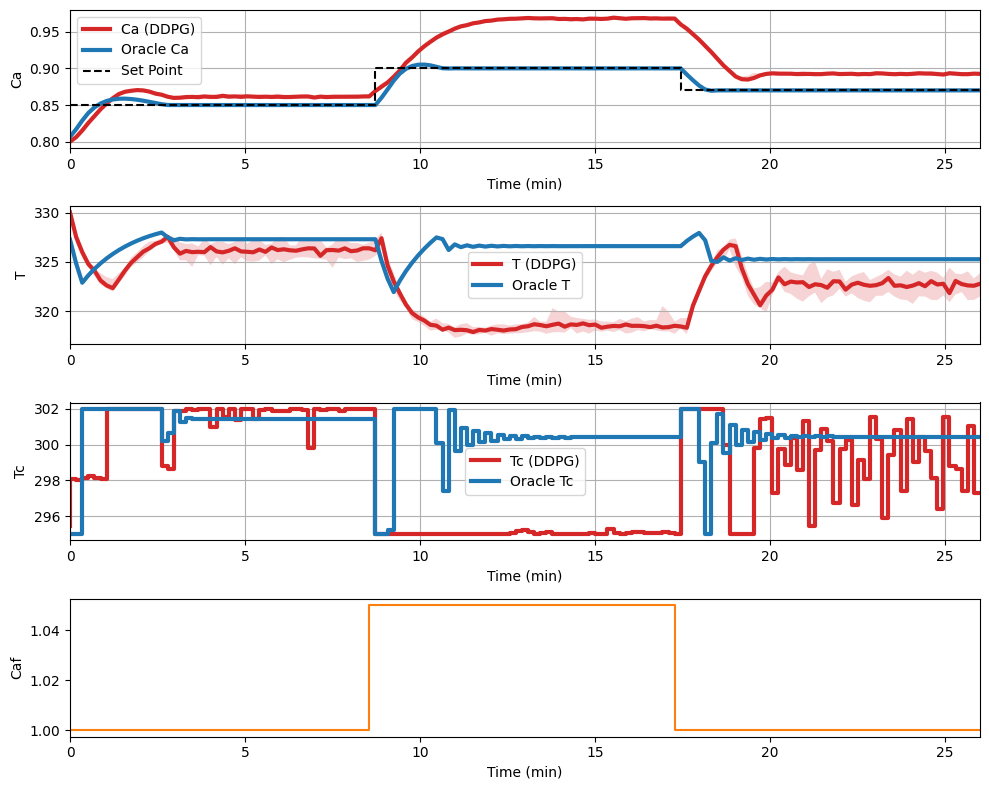

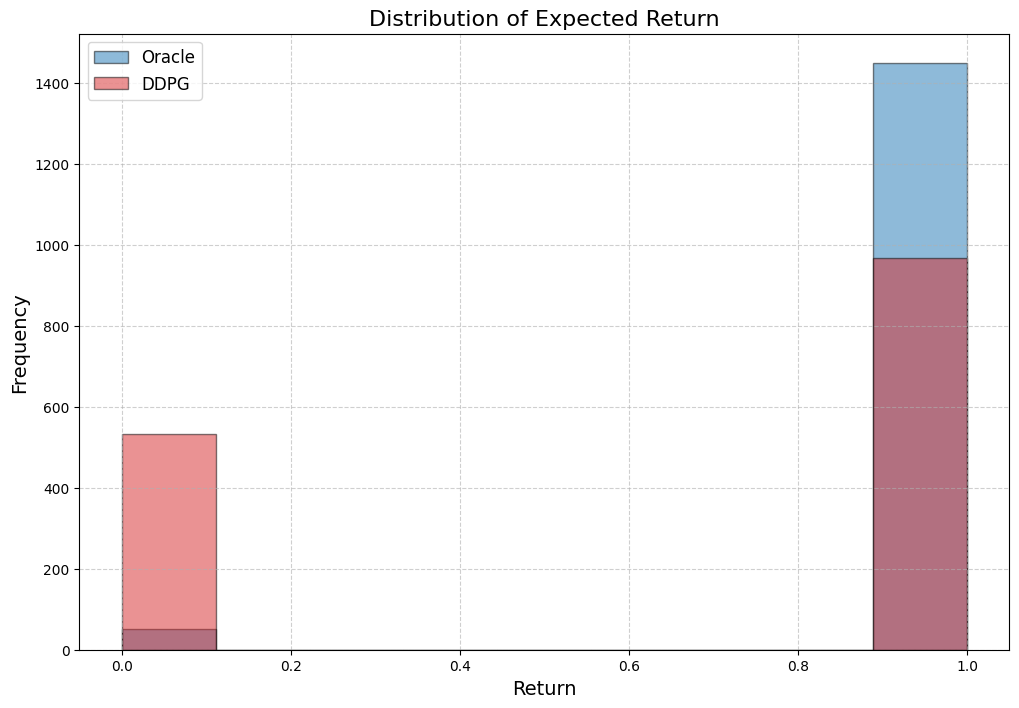

for Epsilon: 0.01, Steps: 70000
Final score is: 0.644667 (larger the better).


In [9]:
epsilon = 0.01
n_steps_learning = 70000
eva, data, score = train_ddpg_with_params(epsilon, n_steps_learning)